In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

run_dir = "../models"
task = "rbf_logistic_regression"
run_id = "trained"  # if you train more models, replace with the run_id from the table above
run_path = os.path.join(run_dir, task, run_id)

In [10]:
import numpy as np
import random

def fix_seed():
    np.random.seed(42)
    torch.manual_seed(42)
    random.seed(42)
    torch.cuda.manual_seed(42)

In [11]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [12]:
model, conf = get_model_from_run(run_path)

n_dims = 2
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [13]:
fix_seed()
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [14]:
xs_flat, ys_flat = xs[0], ys[0]
xs_flat_ones = xs_flat[ys_flat == 1]
xs_flat_zeros = xs_flat[ys_flat == -1]

In [15]:
def get_rbf_db(center, xs_b):
    broadcast_center = center.reshape(1, 1, center.shape[0])
    dist = (torch.cdist(xs_b, broadcast_center).squeeze(-1))
    medians, _ = torch.median(dist, dim=1, keepdim=True)
    medians += 1e-6
    return medians

In [16]:
db_radius = get_rbf_db(task.center, xs_flat).item()

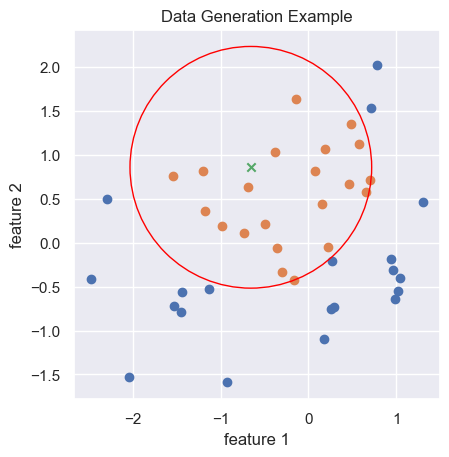

In [18]:
fig, ax = plt.subplots()
ax.set_title("Data Generation Example")
ax.set_aspect(1)
ax.scatter(xs_flat_ones[:, 0], xs_flat_ones[:, 1])
ax.scatter(xs_flat_zeros[:, 0], xs_flat_zeros[:, 1])
ax.scatter(task.center[0], task.center[1], marker='x')
ax.set_xlabel("feature 1")
ax.set_ylabel("feature 2")
db = plt.Circle((task.center[0], task.center[1]), db_radius, fill=False, color='red')
ax.add_patch(db)
plt.show()